In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit, GridSearchCV, train_test_split
from sklearn.metrics import recall_score, mean_squared_error, precision_score, f1_score, accuracy_score, roc_curve, roc_auc_score
#from sklearn.datasets import load_boston
from sklearn.metrics import auc, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import f_classif, mutual_info_classif

from scipy.stats import chi2_contingency
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import re
import math
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/home/stormrider/Desktop/Python/Credit_score/test.csv
/home/stormrider/Desktop/Python/Credit_score/train.csv
/home/stormrider/Desktop/Python/Credit_score/credit_score_backup.ipynb
/home/stormrider/Desktop/Python/Credit_score/sample_submission.csv
/home/stormrider/Desktop/Python/Credit_score/.ipynb_checkpoints/credit_score_backup-checkpoint.ipynb


In [2]:
# зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt

In [3]:
DATA_DIR = '/home/stormrider/Desktop/Python/Credit_score/'
df_train = pd.read_csv(DATA_DIR+'/train.csv')
df_test = pd.read_csv(DATA_DIR+'/test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [4]:
def null_count(column):
    """Вывод информации о количестве пропущенных значений"""

    print(' Кол-во наблюдений:', column.isnull().count(), '\n',
          'Кол-во пропущенных значений:', column.isnull().sum(), '\n',
          'Процент пропущенных значений:',
          int(round(column.isnull().sum()/column.isnull().count()*100, 0)), '%', '\n',
          'Кол-во уникальных значений:', column.nunique())


def get_plot(column):
    """Вывод графика"""

    plt.figure(figsize=(14, 14))
    column.value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title('Number of observations')
    plt.show()


def to_numeric(data_f):
    """Преобразование признаков"""

    data_f = pd.get_dummies(data_f, columns=[
                            'home_address', 'work_address', 'sna', 'first_time'], dummy_na=False)
    data_f = pd.get_dummies(data_f, columns=['education'], dummy_na=True)
    data_f.sex = data_f.sex.apply(lambda x: 0 if x == 'F' else 1)
    for column in ['car', 'car_type', 'foreign_passport']:
        data_f[column] = data_f[column].apply(lambda x: 1 if x == 'Y' else 0)
    data_f.income = data_f.income.apply(lambda x: math.log(x))
    data_f['month'] = data.app_date.apply(lambda x: datetime.strptime(x,
                                                                      '%d%b%Y').month)
    # data_f['month']=data['month'].apply(lambda x: jun if x==1
    # else feb if x==2
    # else mar if x==3
    # else apr)
    data_f['day_of_week'] = data.app_date.apply(lambda x: datetime.strptime(x,
                                                                            '%d%b%Y').isoweekday())
    # data_f['day_of_week']=data['day_of_week'].apply(lambda x: sun if x==1
    # else mon if x==2
    # else tue if x==3
    # else wed if x==4
    # else thu if x==5
    # else fri if x==6
    # else sat)
    #max_date=data_f.app_date.apply(lambda x: datetime.strptime(x, '%d%b%Y')).max()
    #data_f.app_date=data.app_date.apply(lambda x: (max_date-datetime.strptime(x, '%d%b%Y')))
    data_f = data_f.drop(['client_id', 'app_date'],
                         axis='columns', inplace=False)
    data_f = pd.get_dummies(
        data_f, columns=['month', 'day_of_week'], dummy_na=False)
    return data_f


def visualize_train_valid_counts(y_train, y_test):
    "Функция визуализации распределения значений целевого признака в выборках"
    x = np.array([0, 1])

    width = 0.2
    plt.figure(figsize=(15, 8))
    ax = plt.subplot(111)

    ax.bar(x - width, (pd.Series(y_train).value_counts()/pd.Series(y_train).count() * 100).tolist(),
           width, color='r', label='Тренеровочная выборка')
    ax.bar(x, (pd.Series(y_test).value_counts()/pd.Series(y_test).count() * 100).tolist(),
           width, color='g', label='Валидационная выборка')

    #ax.set_ylim([0, 1])
    plt.xticks(x-width/2, ['Отсутствие дефолта',
                           'Наличие дефолта'], fontsize=20)
    plt.yticks(fontsize=15)
    plt.ylabel('Кол-во примеров, %', fontsize=20)
    plt.minorticks_on()
    plt.grid(which='major', color='r')
    plt.grid(which='minor', linestyle=':', color='k')
    plt.legend(fontsize=15)

Тренировочный набор данных

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
client_id           73799 non-null int64
app_date            73799 non-null object
education           73492 non-null object
sex                 73799 non-null object
age                 73799 non-null int64
car                 73799 non-null object
car_type            73799 non-null object
decline_app_cnt     73799 non-null int64
good_work           73799 non-null int64
score_bki           73799 non-null float64
bki_request_cnt     73799 non-null int64
region_rating       73799 non-null int64
home_address        73799 non-null int64
work_address        73799 non-null int64
income              73799 non-null int64
sna                 73799 non-null int64
first_time          73799 non-null int64
foreign_passport    73799 non-null object
default             73799 non-null int64
dtypes: float64(1), int64(12), object(6)
memory usage: 10.7+ MB


In [6]:
df_train.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


Тестовый набор данных

In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
client_id           36349 non-null int64
app_date            36349 non-null object
education           36178 non-null object
sex                 36349 non-null object
age                 36349 non-null int64
car                 36349 non-null object
car_type            36349 non-null object
decline_app_cnt     36349 non-null int64
good_work           36349 non-null int64
score_bki           36349 non-null float64
bki_request_cnt     36349 non-null int64
region_rating       36349 non-null int64
home_address        36349 non-null int64
work_address        36349 non-null int64
income              36349 non-null int64
sna                 36349 non-null int64
first_time          36349 non-null int64
foreign_passport    36349 non-null object
dtypes: float64(1), int64(11), object(6)
memory usage: 5.0+ MB


In [8]:
df_test.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


Для корректной обработки признаков объединяем тренировочный и тестовый наборы данных в один датасет

In [9]:
df_train['sample'] = 1  # помечаем где у нас тренировочный датасет
df_test['sample'] = 0  # помечаем где у нас тестовый датасет
# В тестовом наборе данных нет значения Rating.
# Мы его должны предсказать, по этому пока просто заполняем нулями.
df_test['default'] = 0

data = df_test.append(df_train, sort=False).reset_index(drop=True)

Подробнее по признакам:
* client_id: ID клиента в наборе данных
* app_date: Дата наблюдения
* education: Уровень образования
* sex: Пол заёмщика
* age: Возраст заемщика
* car: Флаг наличия автомобиля
* car_type: Флаг автомобиля-иномарки
* decline_app_cnt: Количество отказанных прошлых заявок
* good_work: Флаг наличия «хорошей» работы
* score_bki: Кредитный рейтинг
* bki_request_cnt: Количество запросов в БКИ
* region_rating: Рейтинг региона
* home_address: Категоризатор домашнего адреса
* work_address: Категоризатор рабочего адреса
* income: Доход заёмщика
* sna: Связь заемщика с клиентами банка
* first_time: Давность наличия информации о заемщике
* foreign_passport: Наличие загранпаспорта
* default: Наличие дефолта ( целевой параметр)

# 1 EDA

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
client_id           110148 non-null int64
app_date            110148 non-null object
education           109670 non-null object
sex                 110148 non-null object
age                 110148 non-null int64
car                 110148 non-null object
car_type            110148 non-null object
decline_app_cnt     110148 non-null int64
good_work           110148 non-null int64
score_bki           110148 non-null float64
bki_request_cnt     110148 non-null int64
region_rating       110148 non-null int64
home_address        110148 non-null int64
work_address        110148 non-null int64
income              110148 non-null int64
sna                 110148 non-null int64
first_time          110148 non-null int64
foreign_passport    110148 non-null object
sample              110148 non-null int64
default             110148 non-null int64
dtypes: float64(1), int64(13), object(6)


Данные можно разделить на следующие категории:
1. Числовые признаки: app_date, age, decline_app_cnt, score_bki, bki_request_cnt, region_rating, income;
2. Категориальные признаки: client_id, education, sna, first_time, home_address, work_address;
3. Бинарные признаки: sex, age, car, car_type, good_work, foreign_passport, default.

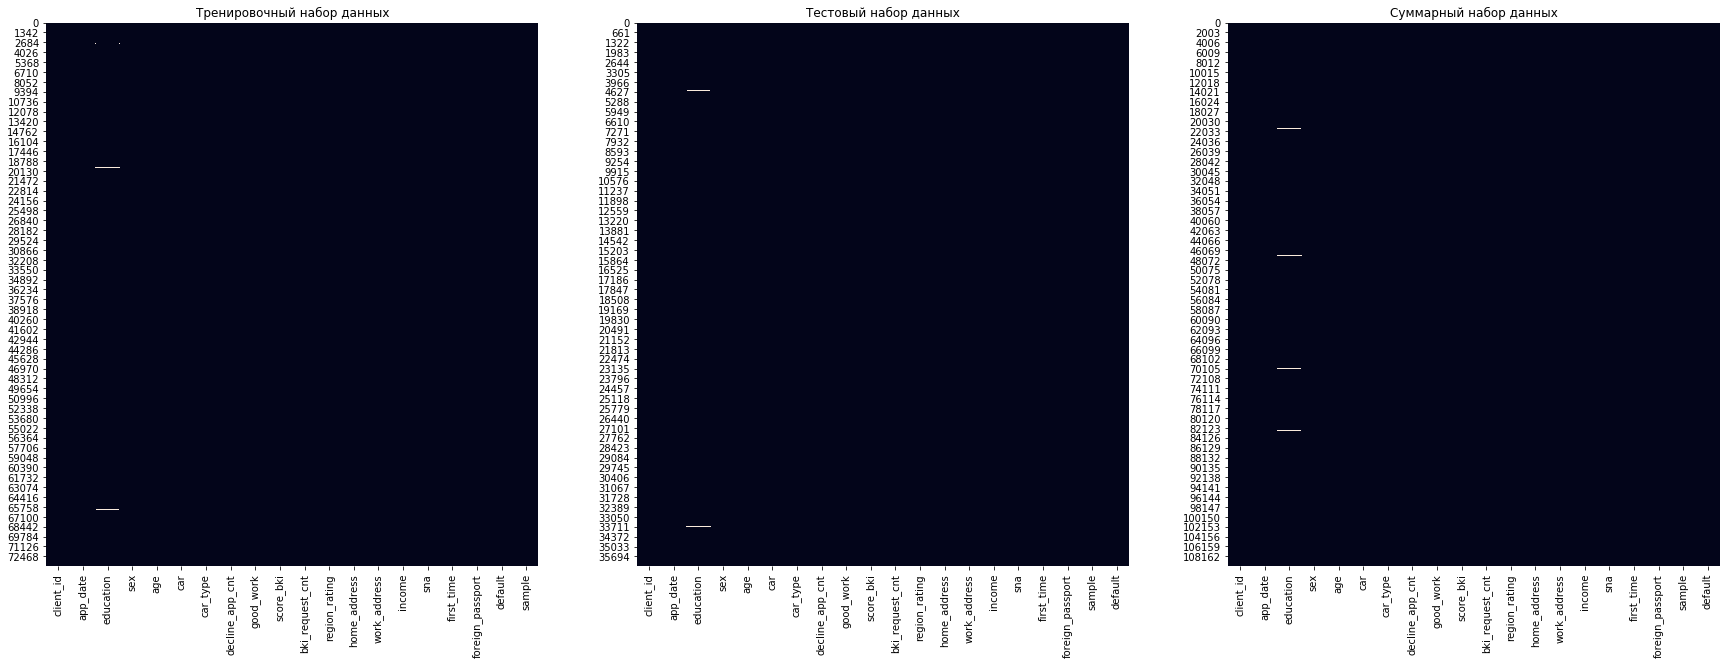

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
ax1.set_title('Тренировочный набор данных')
sns.heatmap(data=df_train.isnull(), cbar=False, ax=ax1)
ax2.set_title('Тестовый набор данных')
sns.heatmap(data=df_test.isnull(), cbar=False, ax=ax2)
ax3.set_title('Суммарный набор данных')
sns.heatmap(data=data.isnull(), cbar=False, ax=ax3)

Как видно из графиков, пропущенные значения тренировочного, тестового и, как следствие, суммарного наборов данных наблюдаются в одом параметре education.

## 1.1 client_id

In [12]:
null_count(data.client_id)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 110148


Данный параметр, характеризующий идентификатор заемщика, имеет количество значений, равное количеству наблюдений. Из этого можно сделать вывод, что данный параметр не поможет обучить модель, его можно исключить перед обучением модели.

## 1.2 app_date

In [13]:
null_count(data.app_date)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 120


Данный параметр характеризует дату наблюдения. Данный параметр будет удобно анализировать, преобразовав в числовой формат.

Посмотрим на год, в котором было проведено наблюдение:

In [14]:
data.app_date.apply(lambda x: re.findall(r'\d\d\d\d', x)[0]).unique()

array(['2014'], dtype=object)

Как видно, все наблюдения были проведены в 2014 году. Информацию о годе наблюдения можно исключить из набора данных перед обучением модели.

Проверим корректность введения месяца и дня даты наблюдения.

In [15]:
data.app_date.apply(lambda x: x[2:5]).value_counts()

MAR    31597
FEB    27097
APR    26266
JAN    25188
Name: app_date, dtype: int64

Названия месяцев введены правильно: Январь, Февраль, Март и Апрель.

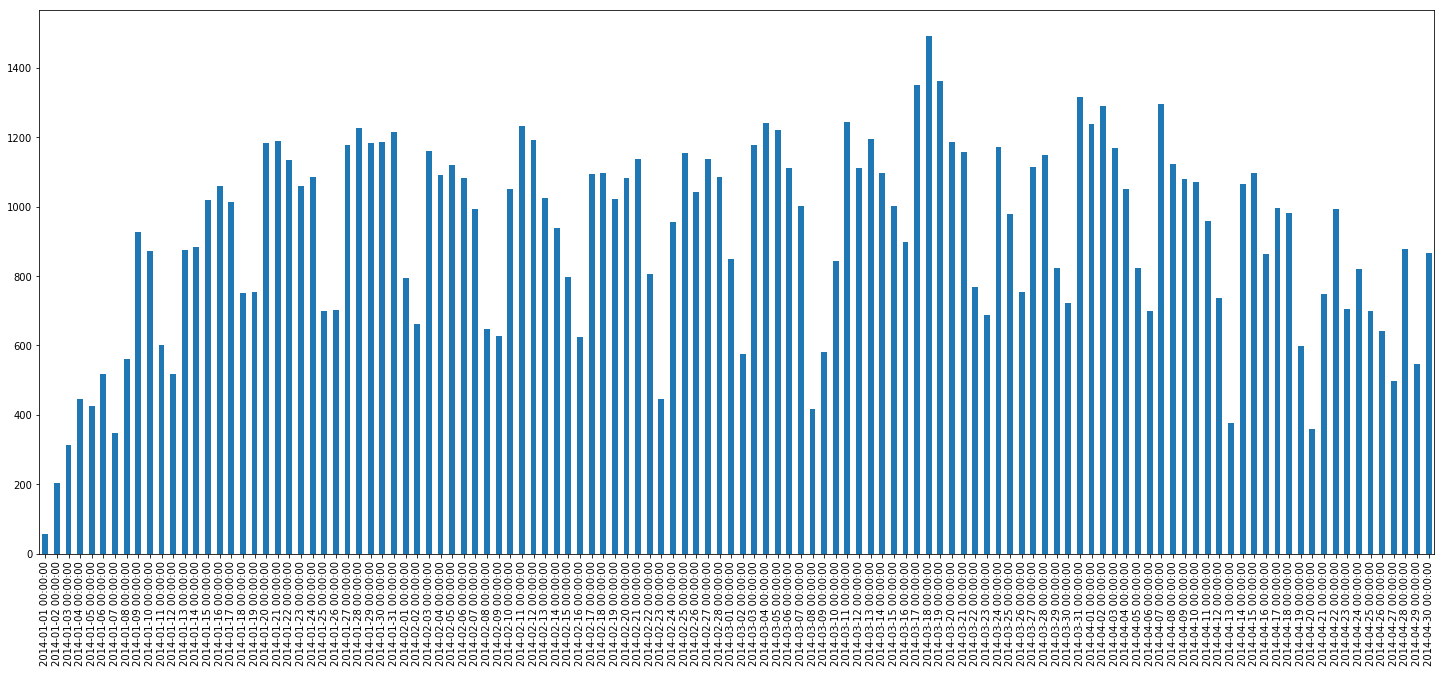

In [16]:
plt.figure(figsize=(25, 10))
data.app_date.apply(lambda x: datetime.strptime(x,
                                                '%d%b%Y')).value_counts().sort_index().plot.bar()

На первый взгляд, наибольшее количество наблюдений произошло в марте. Посмотрим подробнее.

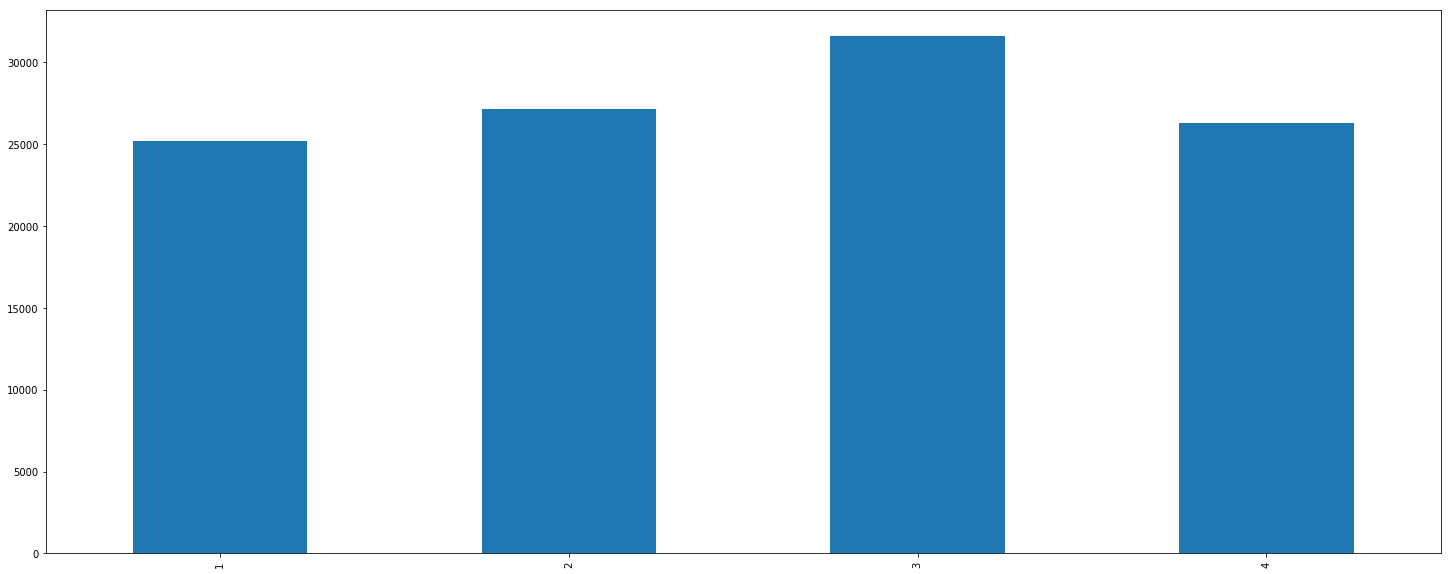

In [17]:
plt.figure(figsize=(25, 10))
data.app_date.apply(lambda x: datetime.strptime(x,
                                                '%d%b%Y').month).value_counts().sort_index().plot.bar()

Действительно, большинство запросов произошло в марте, при этом незначительно отличаясь от запросов, произошедших в течение других месяцев. Посмотрим на распределения количества запросов по дням недели.

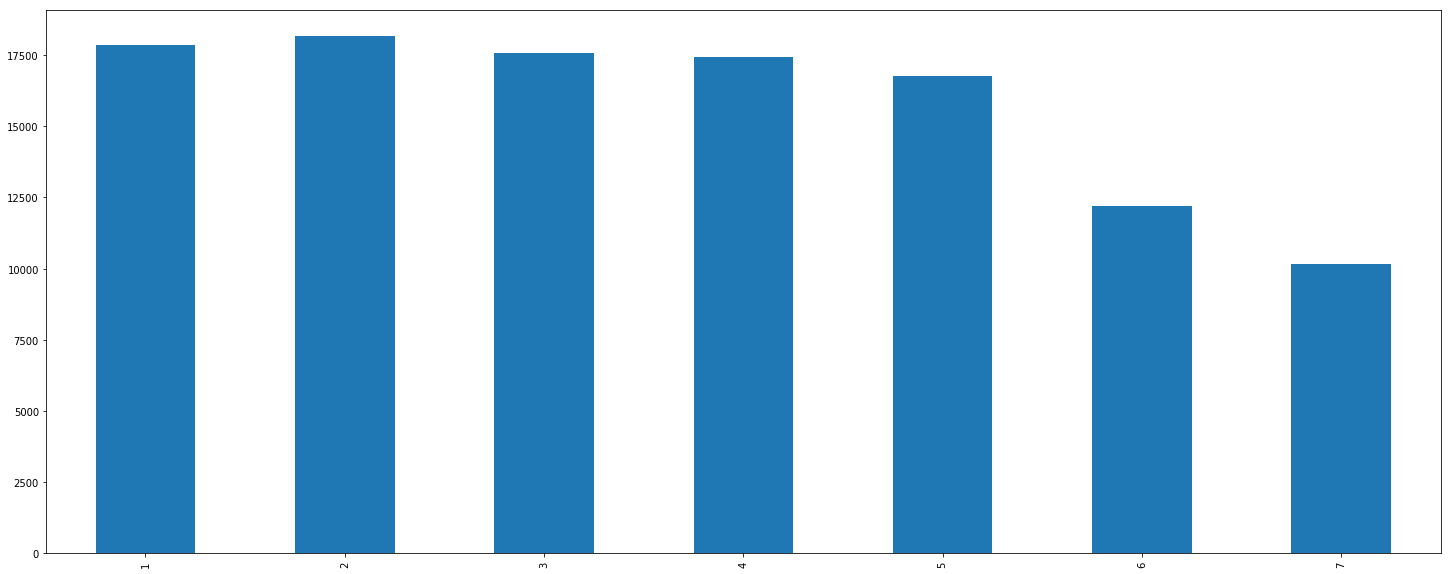

In [18]:
plt.figure(figsize=(25, 10))
data.app_date.apply(lambda x: datetime.strptime(x,
                                                '%d%b%Y').isoweekday()).value_counts().sort_index().plot.bar()

Наименьшее количество запросов произошло пятницу и субботу. Максимальное - в воскресенье и понедельник. В целом, количество запросов в будние дни разбросано незначительно.

##### В дальнейшем выведем следующие параметры: месяцы, дни недели в качестве бинарных признаков и количество дней между самым ранним наблюдением и актуальным наблюдением в качестве числового признака.

## 1.3 education

In [19]:
null_count(data.education)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 478 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 5


Количество пропущенных значений очень мало. Посмотрим на них подробнее.

In [20]:
for column in data.columns.tolist():
    if column != 'education':
        print(column, data[pd.isnull(data.education)
                           == True][column].nunique())
    else:
        continue

client_id 478
app_date 113
sex 2
age 50
car 2
car_type 2
decline_app_cnt 4
good_work 2
score_bki 474
bki_request_cnt 15
region_rating 6
home_address 3
work_address 3
income 77
sna 4
first_time 4
foreign_passport 2
sample 2
default 2


Никаких интересных закономерностей касательно влияния других признаков на исследуемый параметр не замечено.

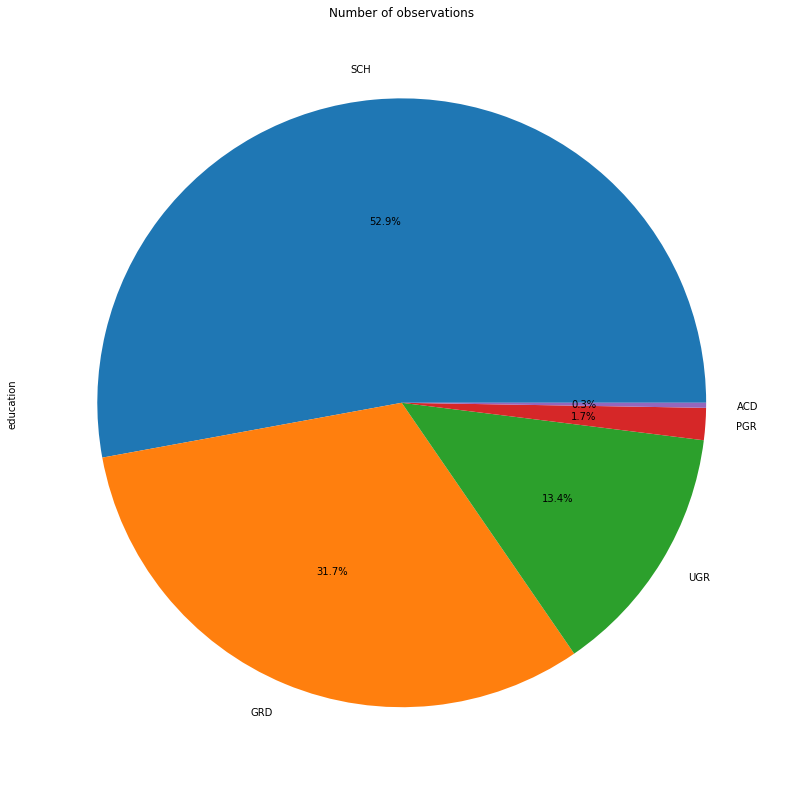

In [21]:
get_plot(data.education)

Видно, что количество наблюдений уменьшается с увеличением уровня образования. Более 50% процентов заемщиков не имеют высшего образования, около 45% являются бакалаврами или кандидатами в бакалавры. Только 2,1% процентов заемщиков являются магистрами и академиками.

Планируется вывести бинарные признаки по значениям данного признака.

## 1.4 sex

In [22]:
null_count(data.sex)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 2


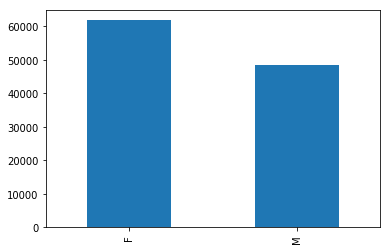

In [23]:
data.sex.value_counts().plot.bar()

Среди заемщиков больше женщин. Перед обучением модели стоит привести данный признак к числовом виду.

## 1.5 age

In [24]:
null_count(data.age)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 52


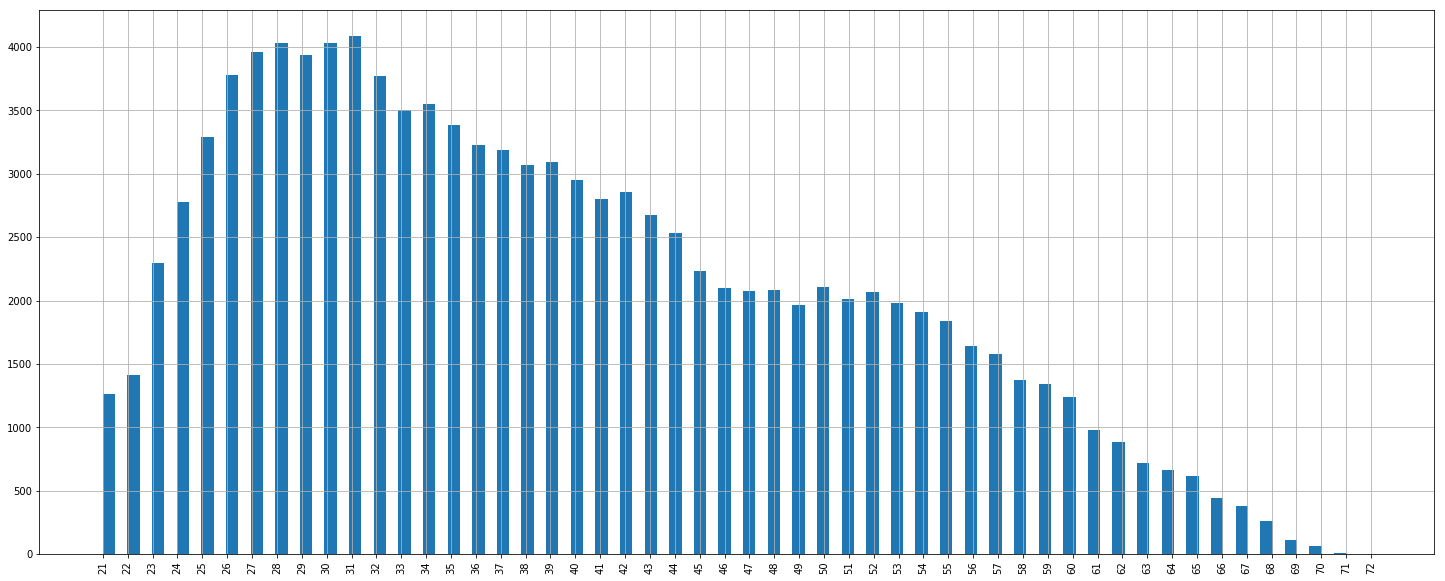

In [25]:
plt.figure(figsize=(25, 10))
plt.xticks(rotation=90, ticks=data.age.unique())
data.age.hist(bins=103)

Как видно, количество заемщиков резко растет до 30-31 лет, далее оно плавно уменьшается с возрастом.

## 1.6 car

In [26]:
null_count(data.car)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 2


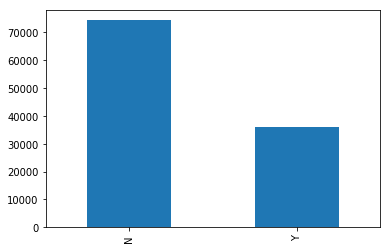

In [27]:
data.car.value_counts().plot.bar()

Большинство заемщиков не имеют автомобилей.

## 1.7 car_type

In [28]:
null_count(data.car_type)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 2


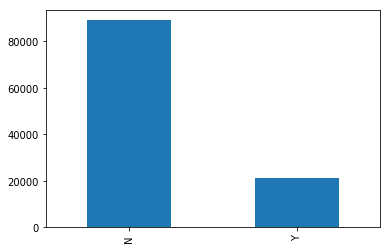

In [29]:
data.car_type.value_counts().plot.bar()

Большинство заемщиков не имеют иностранных автомобилей.

In [30]:
data[data.car_type == 'Y'].car.unique()

array(['Y'], dtype=object)

Как видно, логических ошибок в вводе данных в признаках car и car_type нет.

## 1.8 decline_app_cnt

In [31]:
null_count(data.decline_app_cnt)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 24


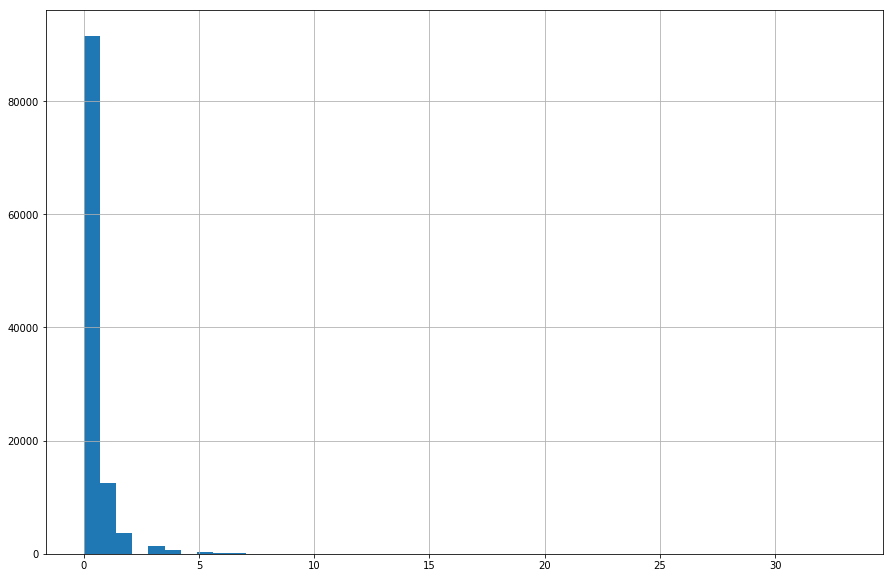

In [32]:
plt.figure(figsize=(15, 10))
data.decline_app_cnt.hist(bins=47)

Большинство заемщиков из выборки не имеют отклоненных заявок. Небольшое количество имеют 1-2 отклоненные заявки. Количество заемщиков с количеством отклоненных заявок не менее 2 очень мало. Основываясь на данном параметре можно выделить следующий бинарный признак: наличие отклоненных заявок.

## 1.9 good_work

In [33]:
null_count(data.good_work)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 2


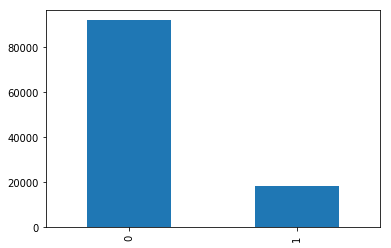

In [34]:
data.good_work.value_counts().plot.bar()

Подавляющее количество наблюдений фиксируют отсутствие "хорошей" работы у заемщиков. Данный признак числовой, не нуждается в предварительной обработке.

## 1.10 score_bki

In [35]:
null_count(data.score_bki)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 102618


Количество уникальных значений параметра практически равно количеству наблюдений.

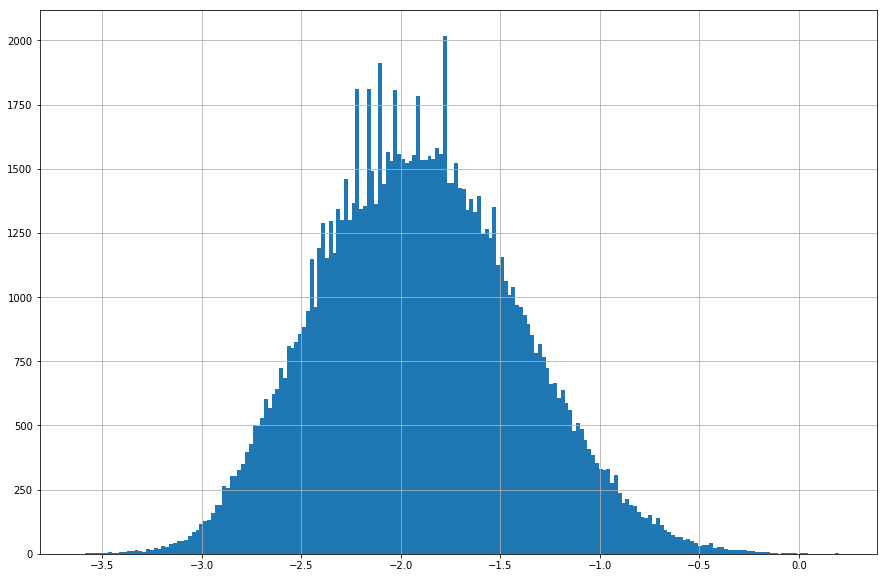

In [36]:
plt.figure(figsize=(15, 10))
data.score_bki.hist(bins=200)

Видно, что признак распределен нормально. Большинство заемщиков имеют "средний" рейтинг. При этом количество заемщиков при отклонении их рейтинга от "среднего" значения резко уменьшается.

## 1.11 bki_request_cnt

In [37]:
null_count(data.bki_request_cnt)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 40


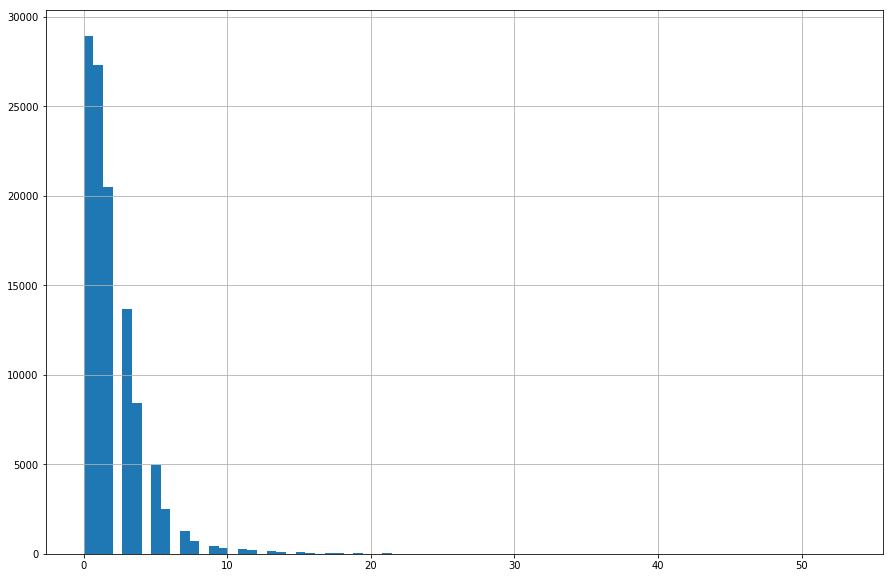

In [38]:
plt.figure(figsize=(15, 10))
data.bki_request_cnt.hist(bins=79)

Большинство наблюдений имеют от 0 до 2 запросов в БКИ. Можно выедлить бинарный признак: отсутствие более двух запросов.

## 1.12 region_rating

In [39]:
null_count(data.region_rating)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 7


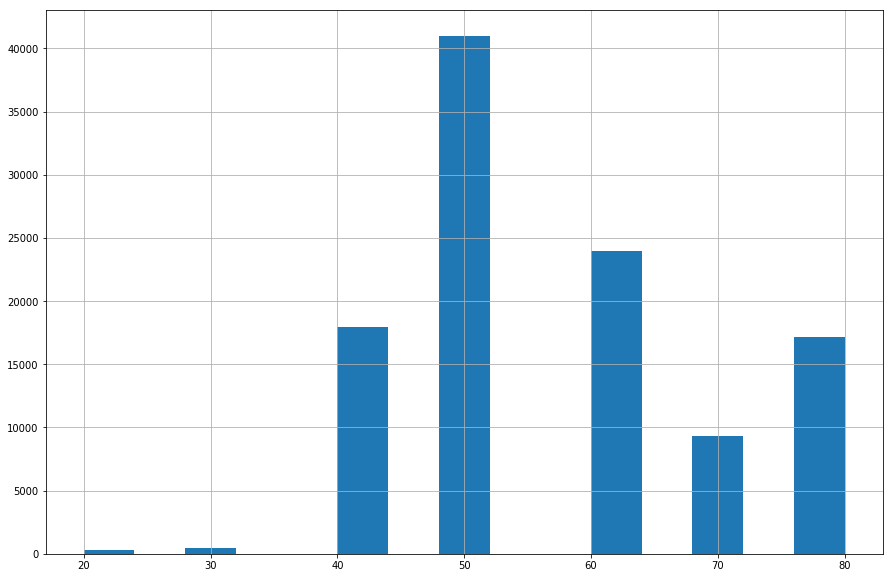

In [40]:
plt.figure(figsize=(15, 10))
data.region_rating.hist(bins=15)

Видно, что признак распределен нормально. Большинство наблюдений имеют "средний" рейтинг региона. При этом количество наблюдений при отклонении рейтинга региона от "среднего" значения уменьшается: резко слева и плавно справа.

## 1.13 home_address

In [41]:
null_count(data.home_address)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 3


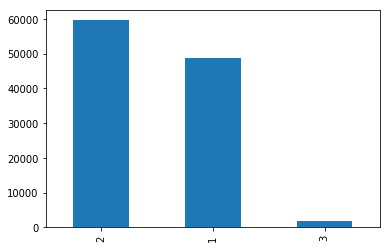

In [42]:
data.home_address.value_counts().plot.bar()

Большинство наблюдений имеют 2 и 1 категории домашнего адреса. В дальнейшем стоит вывести бинарные признаки по данным категориям.

## 1.14 work_address

In [43]:
null_count(data.work_address)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 3


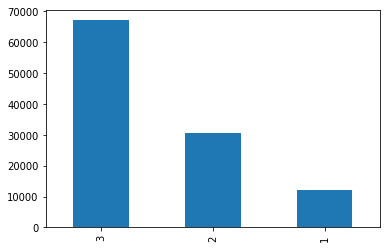

In [44]:
data.work_address.value_counts().plot.bar()

Количество наблюдений резко увеличивается при увеличении категории места работы. Далее Выведем бинарные признаки по данным категориям.

## 1.15 income

In [45]:
null_count(data.income)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 1207


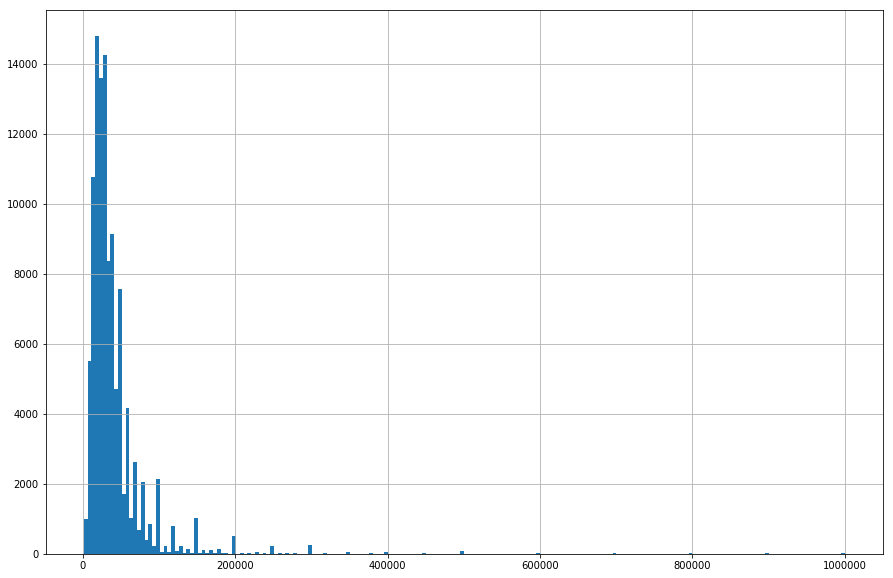

In [46]:
plt.figure(figsize=(15, 10))
data.income.hist(bins=200)

Данный признак имеет "хвост" справа. Попробуем нормализовать данный параметр путем логарифмирования.

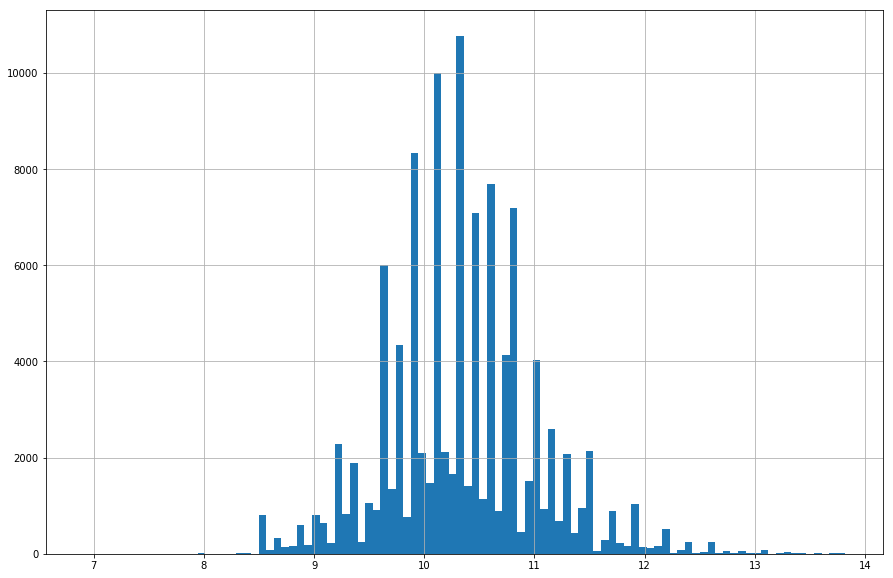

In [47]:
plt.figure(figsize=(15, 10))
data.income.apply(lambda x: math.log(x)).hist(bins=100)

После логарифмирования признак имеет нормальное распределение. В дальнейшем стоит провести операцию логарифмирования.

## 1.16 sna

In [48]:
null_count(data.sna)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 4


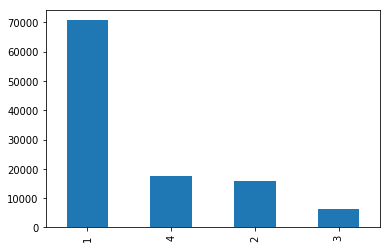

In [49]:
data.sna.value_counts().plot.bar()

Большинство наблюдений имеют значение параметра 1. В дальнейшем выведем бинарные признаки по данным категориям.

## 1.17 first_time

In [50]:
null_count(data.first_time)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 4


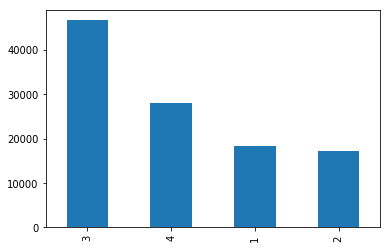

In [51]:
data.first_time.value_counts().plot.bar()

Большинство наблюдений имеют значение параметра 3. Количество значений 1, 2, 4 в среднем составляют половину от количества значений 3. Далее добавим бинарные признаки по данным значениям в набор данных.

## 1.18 foreign_passport

In [52]:
null_count(data.foreign_passport)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 2


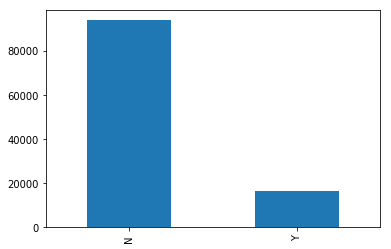

In [53]:
data.foreign_passport.value_counts().plot.bar()

Большинство заемщиков не имеют загранпаспорта. Далее стоит привести данный признак к числовому виду.

## 1.19 default ( целевой параметр)

In [54]:
null_count(data.default)

 Кол-во наблюдений: 110148 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 2


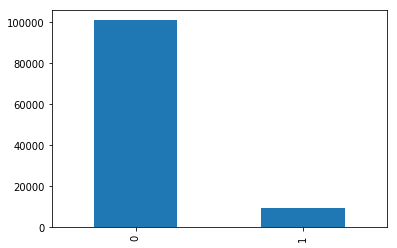

In [55]:
data.default.value_counts().plot.bar()

Подавляющее количество заемщиков не имеют дефолта по кредиту.

## 1.20 Корреляция признаков
### Корреляция числовых признаков.

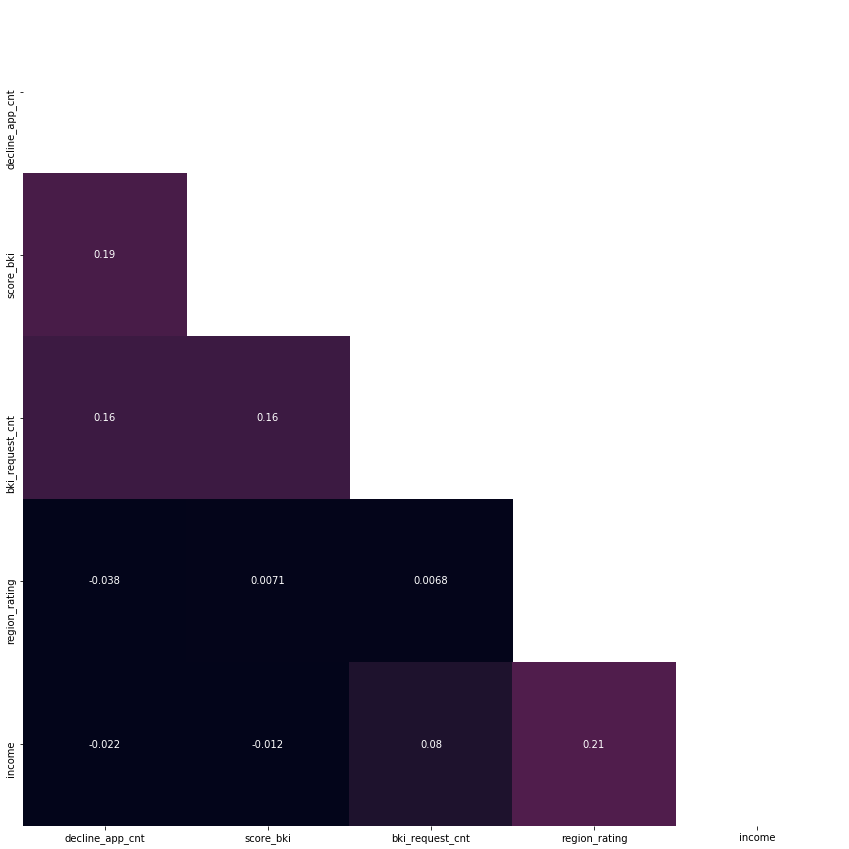

In [56]:
mask = np.zeros_like(data.drop(['client_id', 'education', 'sna', 'first_time',
                                'work_address', 'home_address', 'sex', 'age',
                                'car', 'car_type', 'good_work', 'foreign_passport',
                                'default','sample'], axis='columns').corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(15, 15))
with sns.axes_style("white"):
    ax = sns.heatmap(data.drop(['client_id', 'education', 'sna', 'first_time',
                                'work_address', 'home_address', 'sex', 'age',
                                'car', 'car_type', 'good_work', 'foreign_passport',
                                'default','sample'], axis='columns').corr(), mask=mask, vmin=0.,
                     vmax=1, square=True, annot=True, cbar=False)

plt.show()

##### Максимальную корреляцию можно увидеть между признаками region_rating и bki_request_cnt, 0.21. Нет оснований для исключения каких-либо параметров.

### Корреляция категориальных признаков.

In [57]:
def cramers_V(var1, var2):
    """Метод крамера"""

    # Построение таблицы сопряженности для двух параметров
    confusion_matrix = np.array(pd.crosstab(
        var1, var2, rownames=None, colnames=None))
    # Получение расчитанной статистики. Нам нужен только первый возвращаемый аргумент
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1), (rcorr-1)))

In [58]:
# Получаем датафрейм без числовых параметров
#data_cat = data.drop(['decline_app_cnt', 'score_bki', 'bki_request_cnt',
                      #'region_rating', 'income', 'default', 'sample'],
                     #axis='columns', inplace=False)

# Создание матрицы корреляций
#rows = []

#for var1 in data_cat:
    # Создание списка-столбца для двумерной матрицы
    #col = []
    #for var2 in data_cat:
        # Тест Cramer's V
        #cramers = cramers_V(data_cat[var1], data_cat[var2])
        # Заполнение списка-столбца мерами корреляции с округлением
        # до 2 чисел после запятой
        #col.append(round(cramers, 2))
    # Добавление списка-столбца в матрицу
    #rows.append(col)

# Создание датафрейма из матрицы корреляций
#cramers_results = np.array(rows)
#cat_corr = pd.DataFrame(cramers_results, columns=data_cat.columns,
                        #index=data_cat.columns)

# 2 Feature Engineering

##### По результатам разведочного анализа данных проведем следующие преобразования в наборе данных:
* Удалим client_id;
* Преобразуем бинарные признаки sex, car, car_type, foreign_passport в числовой формат;
* Преобразуем значения категориальных признаков home_address, work_address, sna, first_time, education в бинарные признаки;
* Преобразуем признак app_date в бинарные признаки месяцев и дней недели;
* Логарифмируем признак income.

In [59]:
data_mod=to_numeric(data)

## 2.1 Значимость числовых признаков на целевой параметр

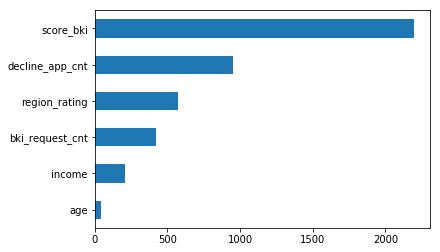

In [61]:
imp_num = pd.Series(f_classif(data_mod[[
    'age', 'decline_app_cnt',
    'score_bki', 'bki_request_cnt',
    'region_rating', 'income']], data_mod['default'])[0],
    index=['age', 'decline_app_cnt',
           'score_bki', 'bki_request_cnt',
           'region_rating', 'income'])
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

Самым значимым числовым параметром является кредитный рейтинг. Наименее значимым - возраст заемщика.

## 2.2 Значимость бинарных признаков на целевой параметр

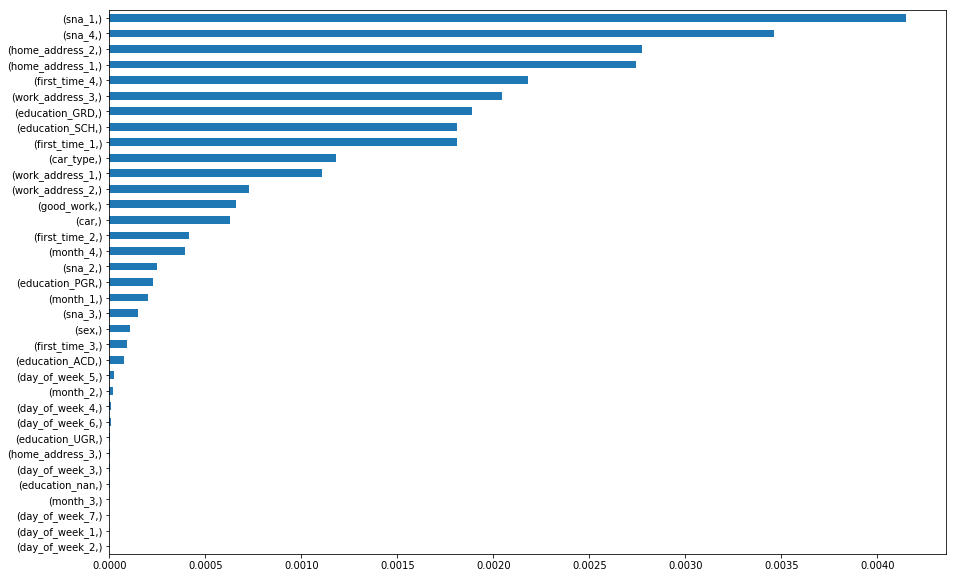

In [62]:
imp_cat = pd.Series(mutual_info_classif(data_mod[[
    'sex', 'car', 'car_type', 'good_work', 'home_address_1',
    'home_address_2', 'home_address_3', 'work_address_1',
    'work_address_2', 'work_address_3', 'sna_1', 'sna_2', 'sna_3',
    'sna_4', 'first_time_1', 'first_time_2',
    'first_time_3', 'first_time_4', 'education_ACD',
    'education_GRD', 'education_PGR', 'education_SCH',
    'education_UGR', 'education_nan', 'month_1', 'month_2',
    'month_3', 'month_4', 'day_of_week_1', 'day_of_week_2',
    'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
    'day_of_week_6', 'day_of_week_7']], data_mod['default'], discrete_features=True),
    index=[['sex', 'car', 'car_type', 'good_work', 'home_address_1',
            'home_address_2', 'home_address_3', 'work_address_1',
            'work_address_2', 'work_address_3', 'sna_1', 'sna_2',
            'sna_3', 'sna_4', 'first_time_1',
            'first_time_2', 'first_time_3', 'first_time_4',
            'education_ACD', 'education_GRD', 'education_PGR',
            'education_SCH', 'education_UGR', 'education_nan',
            'month_1', 'month_2', 'month_3', 'month_4',
            'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
            'day_of_week_4', 'day_of_week_5', 'day_of_week_6',
            'day_of_week_7']])
imp_cat.sort_values(inplace=True)
plt.figure(figsize=(15, 10))
imp_cat.plot(kind='barh')

Удалим признаки с невысокой значимостью:

In [63]:
data_mod.drop(['day_of_week_1', 'day_of_week_2', 'day_of_week_3',
               'day_of_week_4', 'day_of_week_5', 'day_of_week_6',
               'day_of_week_7', 'month_1', 'month_2', 'month_3',
               'month_4', 'education_nan', 'education_ACD', 'education_UGR',
               'education_PGR', 'home_address_3', 'first_time_3',
               'sex', 'sna_2', 'sna_3', 'first_time_2'], axis=1, inplace=True)

# 3 ML

#### Для обучения модели применим hold-out разбиение.
Разобъем набор данных на обучающую и тестовую выборки:

In [64]:
train_data = data_mod.query('sample == 1').drop(['sample'], axis=1)
test_data = data_mod.query('sample == 0').drop(['sample'], axis=1)

Стандартизируем числовые признаки обучающего набора данных:

In [65]:
X_num = StandardScaler().fit_transform(train_data[[
    'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt',
    'region_rating', 'income']].values)

Объединим стандартизованные числовые и бинарные признаки в одно признаковое пространство, разделив при этом признаки и целевую переменную:

In [66]:
X_bin_cat = train_data[[
    'car', 'car_type', 'good_work', 'home_address_1',
    'home_address_2', 'work_address_1',
    'work_address_2', 'work_address_3', 'sna_1', 'sna_4',
    'first_time_1', 'first_time_4', 'education_GRD',
    'education_SCH','good_work']].values

In [67]:
X = np.hstack([X_num, X_bin_cat])
Y = train_data['default'].values

Разобьем обучающую выборку на тренеровочную и валидационную выборки:

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42, shuffle=True)

In [69]:
def visualize_train_valid_counts(y_train, y_test):
    "Функция визуализации распределения значений целевого признака в выборках"
    x = np.array([0, 1])
    width = 0.2
    plt.figure(figsize=(15, 8))
    ax = plt.subplot(111)

    ax.bar(x - width, (pd.Series(y_train).value_counts()/pd.Series(y_train).count()*100).tolist(), width, color='r', label='Тренеровочная выборка')
    ax.bar(x, (pd.Series(y_test).value_counts()/pd.Series(y_test).count()*100).tolist(), width, color='g', label='Валидационная выборка')

    #ax.set_ylim([0, 1])
    plt.xticks(x-width/2, ['Отсутствие дефолта','Наличие дефолта'], fontsize=20)
    plt.yticks(fontsize=15)
    plt.ylabel('Кол-во примеров, %', fontsize=20)
    plt.minorticks_on()
    plt.grid(which='major', color='r')
    plt.grid(which='minor', linestyle=':', color='k')
    plt.legend(fontsize=15)

Посмотрим, как распределены значения целевого параметра в тренировочной и валидационной выборках:

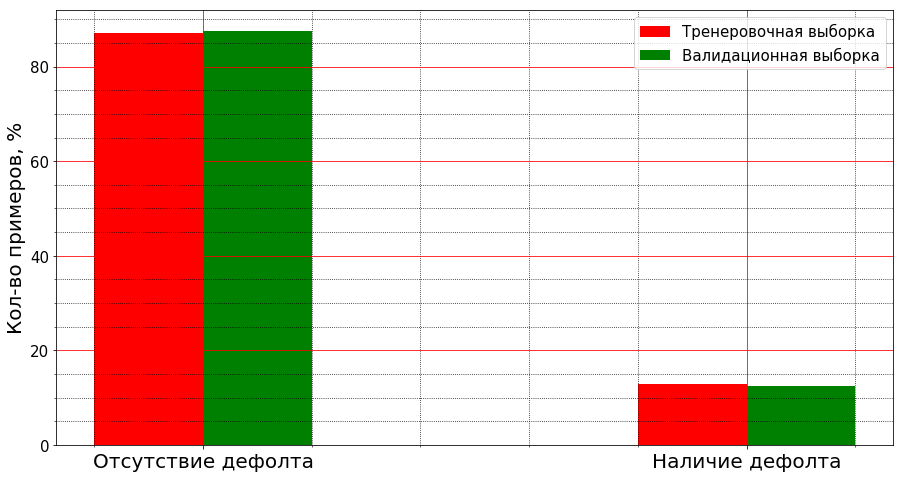

In [70]:
visualize_train_valid_counts(y_train,y_test)

Рассмотрим несколько моделей: логистическую регрессию, случайный лес и метод k-ближайших соседей:

In [71]:
model_logreg = LogisticRegression()
model_logreg.fit(X_train, y_train)

LogisticRegression()

In [72]:
model_rfc = RandomForestClassifier(n_estimators = 200)
model_rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [73]:
model_knc = KNeighborsClassifier(n_neighbors = 50)
model_knc.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=50)

Оценим качество моделей:

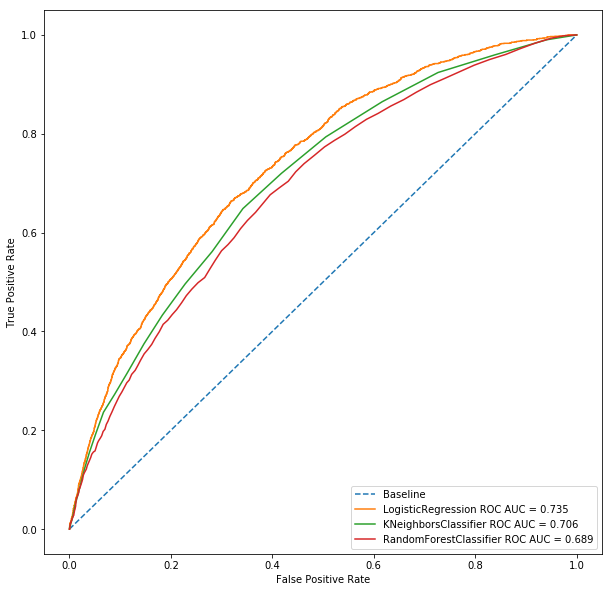

In [74]:
plt.figure(figsize=(10,10))
plt.plot([0, 1], label='Baseline', linestyle='--')

probs = model_logreg.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)
plt.plot(fpr, tpr, label = 'LogisticRegression ROC AUC = %0.3f' % roc_auc)

probs = model_knc.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)
plt.plot(fpr, tpr, label = 'KNeighborsClassifier ROC AUC = %0.3f' % roc_auc)

probs = model_rfc.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)
plt.plot(fpr, tpr, label = 'RandomForestClassifier ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Как видно из графика, наибольшая площадь под кривой получается при использовании логистической регрессии.

In [77]:
test_data.drop('default',axis='columns',inplace=True)
X_train = train_data.drop(['default'], axis='columns').values
y_train = train_data.default.values
X_test = test_data.values

In [78]:
model_logreg = LogisticRegression()
model_logreg.fit(X_train, y_train)

/home/stormrider/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [80]:
submission = model_logreg.predict_proba(X_test)[:, 1]
pd.Series(submission).to_csv('submission.csv', index=False)

/home/stormrider/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  
